# An Empirical Comparison of Supervised and Self-Supervised Learning

In [1]:
import tqdm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.svm import SVC
from sklearn.manifold import TSNE

from train import train_encoder, train_ConvNet, TrainArgs
from test import encode_data, plot_tsne, test_conv

from torch.utils.data import Subset

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%load_ext autoreload
%autoreload 2

## Baseline: convolutional neural network

In [3]:
conv_args = TrainArgs(batchsize = 10)

In [4]:
ConvNet, conv_losses = train_ConvNet(conv_args)

100%|██████████| 170498071/170498071 [00:30<00:00, 5570510.97it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Started looping
[epoch: 0, i:   499] avg mini-batch loss: 2.302
[epoch: 0, i:   999] avg mini-batch loss: 2.301
[epoch: 0, i:  1499] avg mini-batch loss: 2.298
[epoch: 0, i:  1999] avg mini-batch loss: 2.292
[epoch: 0, i:  2499] avg mini-batch loss: 2.273
[epoch: 0, i:  2999] avg mini-batch loss: 2.197
[epoch: 0, i:  3499] avg mini-batch loss: 2.109
[epoch: 0, i:  3999] avg mini-batch loss: 2.033
[epoch: 0, i:  4499] avg mini-batch loss: 1.989
[epoch: 0, i:  4999] avg mini-batch loss: 1.927
[epoch: 1, i:   499] avg mini-batch loss: 1.861
[epoch: 1, i:   999] avg mini-batch loss: 1.864
[epoch: 1, i:  1499] avg mini-batch loss: 1.831
[epoch: 1, i:  1999] avg mini-batch loss: 1.767
[epoch: 1, i:  2499] avg mini-batch loss: 1.734
[epoch: 1, i:  2999] avg mini-batch loss: 1.700
[epoch: 1, i:  3499] avg mini-batch loss: 1.680
[epoch: 1, i:  3999] avg mini-batch loss: 1.666
[epoch: 1, i:  4499] avg mini-batch loss: 1.610
[epoch: 1, i:  4999] 

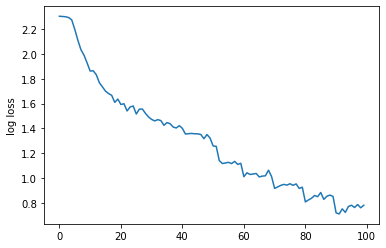

In [5]:
plt.plot(conv_losses);
plt.ylabel('log loss');

In [6]:
print(f'Baseline accuracy of the convolutional model is {test_conv(ConvNet)*100} %')

Files already downloaded and verified
Baseline accuracy of the convolutional model is 63.59 %


## Momentum Contrast

### Pre-Training the Encoder

In [7]:
encoder_args = TrainArgs(epochs = 20)

In [8]:
encoder, enc_losses = train_encoder(encoder_args)

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 	Loss: 0.064828
Train Epoch: 2 	Loss: 0.052827
Train Epoch: 3 	Loss: 0.041022
Train Epoch: 4 	Loss: 0.034503
Train Epoch: 5 	Loss: 0.030834
Train Epoch: 6 	Loss: 0.028695
Train Epoch: 7 	Loss: 0.027336
Train Epoch: 8 	Loss: 0.026209
Train Epoch: 9 	Loss: 0.025462
Train Epoch: 10 	Loss: 0.024901
Train Epoch: 11 	Loss: 0.024458
Train Epoch: 12 	Loss: 0.024105
Train Epoch: 13 	Loss: 0.023793
Train Epoch: 14 	Loss: 0.023531
Train Epoch: 15 	Loss: 0.023308
Train Epoch: 16 	Loss: 0.023192
Train Epoch: 17 	Loss: 0.023000
Train Epoch: 18 	Loss: 0.022858
Train Epoch: 19 	Loss: 0.022710
Train Epoch: 20 	Loss: 0.022684


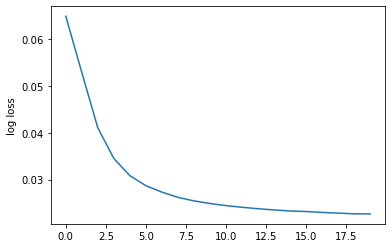

In [9]:
plt.plot(enc_losses);
plt.ylabel('log loss');

### Visualizing Embeddings

To do:
1. Implement multiple training ratios
2. Hyperparameter tuning?
3. Plot the loss functions

In [10]:
data, targets = encode_data()

Files already downloaded and verified


100%|██████████| 10000/10000 [01:41<00:00, 98.51it/s]


In [11]:
ret = TSNE(n_components=2, random_state=0, n_jobs=8).fit_transform(data)

Files already downloaded and verified


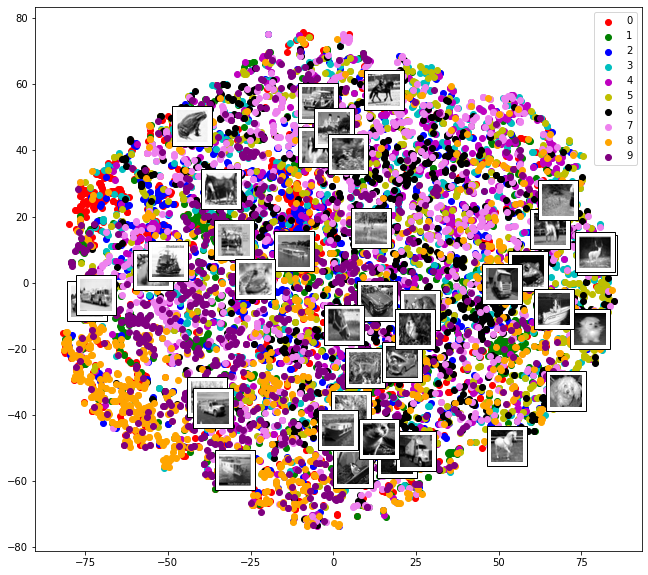

In [12]:
plot_tsne(targets, ret)

### Training SVM on freezed features

In [13]:
X_train, y_train = encode_data(train=True)
X_test, y_test = encode_data(train=False)

Files already downloaded and verified


100%|██████████| 50000/50000 [08:23<00:00, 99.24it/s] 


Files already downloaded and verified


100%|██████████| 10000/10000 [01:40<00:00, 99.07it/s]


In [14]:
svm = SVC(C = 100,  gamma='scale')
svm.fit(X_train, y_train)

SVC(C=100)

In [15]:
svm.score(X_test, y_test)

0.3604

### Multiple Runs

In [16]:
# subsample so things run faster
X_train, y_train = encode_data(train=True, subsample = True)
X_test, y_test = encode_data(train=False, subsample = True)

Files already downloaded and verified


100%|██████████| 5000/5000 [00:50<00:00, 99.74it/s] 


Files already downloaded and verified


100%|██████████| 1000/1000 [00:10<00:00, 99.27it/s]


In [17]:
conv_args = TrainArgs(batchsize = 10, epochs = 5)

In [18]:
n = 3
conv_errors = []
svm_errors = []
for i in range(n):
    ConvNet, conv_losses = train_ConvNet(conv_args, subsample=True)
    conv_errors.append(test_conv(ConvNet, subsample=True)*100)
    
    svm = SVC(C = 100,  gamma='scale')
    svm.fit(X_train, y_train)   
    svm_errors.append(svm.score(X_test, y_test))

Files already downloaded and verified
Started looping
[epoch: 0, i:   499] avg mini-batch loss: 2.302
[epoch: 1, i:   499] avg mini-batch loss: 2.297
[epoch: 2, i:   499] avg mini-batch loss: 2.285
[epoch: 3, i:   499] avg mini-batch loss: 2.229
[epoch: 4, i:   499] avg mini-batch loss: 2.097
Files already downloaded and verified
Files already downloaded and verified
Started looping
[epoch: 0, i:   499] avg mini-batch loss: 2.303
[epoch: 1, i:   499] avg mini-batch loss: 2.302
[epoch: 2, i:   499] avg mini-batch loss: 2.301
[epoch: 3, i:   499] avg mini-batch loss: 2.300
[epoch: 4, i:   499] avg mini-batch loss: 2.299
Files already downloaded and verified
Files already downloaded and verified
Started looping
[epoch: 0, i:   499] avg mini-batch loss: 2.299
[epoch: 1, i:   499] avg mini-batch loss: 2.271
[epoch: 2, i:   499] avg mini-batch loss: 2.191
[epoch: 3, i:   499] avg mini-batch loss: 2.113
[epoch: 4, i:   499] avg mini-batch loss: 2.049
Files already downloaded and verified


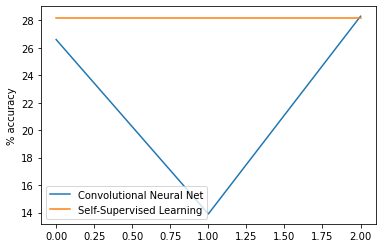

In [19]:
plt.plot(np.array(conv_errors), label="Convolutional Neural Net")
plt.plot(np.array(svm_errors)*100, label="Self-Supervised Learning")
plt.legend()
plt.ylabel('% accuracy')
plt.savefig('./results/comparison.png')

In [20]:
conv_errors

[26.6, 13.900000000000002, 28.299999999999997]

In [21]:
svm_errors

[0.282, 0.282, 0.282]

In [22]:
conv_errors

[26.6, 13.900000000000002, 28.299999999999997]